<a href="https://colab.research.google.com/github/ZhihaoXu0313/ACMS-80770-Deep-Learning-with-Graphs/blob/trunk/Graph_Denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from skimage.util import random_noise
import glob

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
images = glob.glob('./drive/MyDrive/Graph_Denoising/lfw-deepfunneled/*/*.jpg')
len(images)

13233

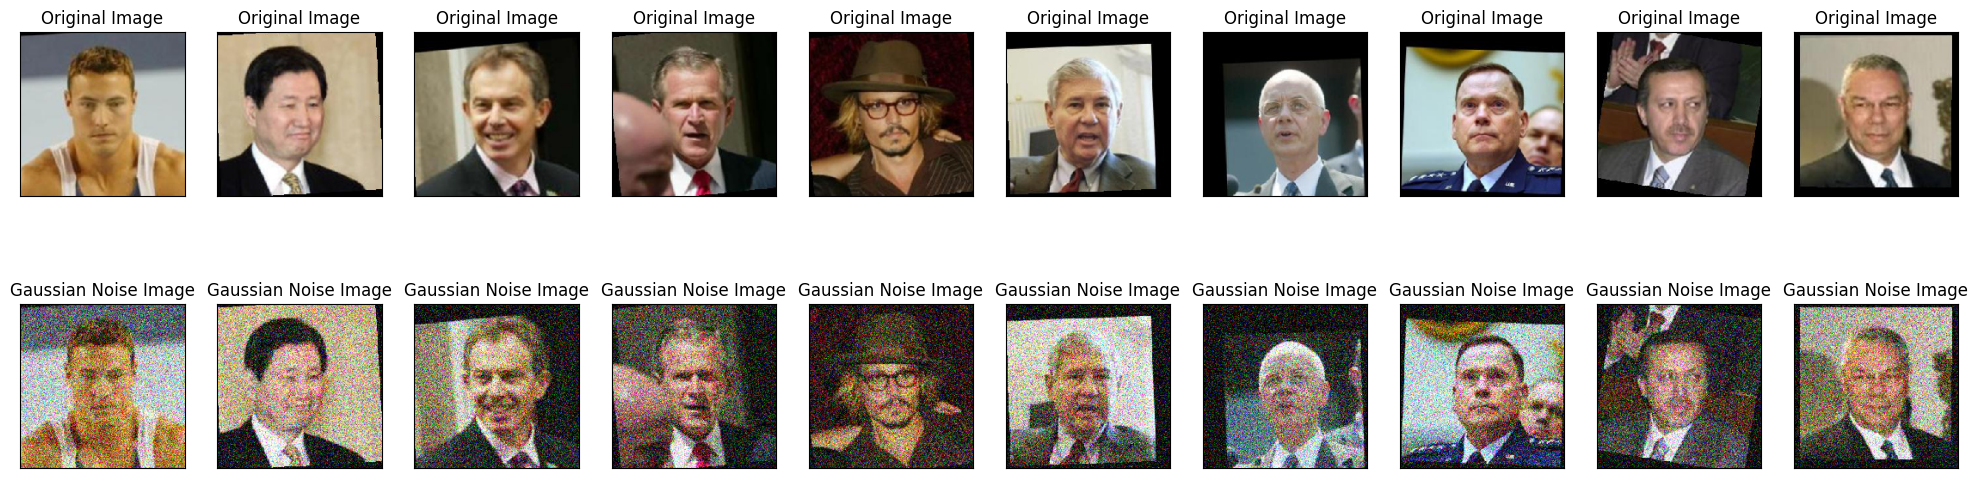

In [ ]:
n = 10
plt.figure(figsize= (25,10))
for i in range(n):
  ax = plt.subplot(3, n, i+1)
  index = np.random.randint(0, len(images))
  img = tf.keras.utils.load_img(str(images[index]), target_size=(192,192,3))
  img = tf.keras.utils.img_to_array(img)/255.
  plt.imshow(img)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title('Original Image')
  ax = plt.subplot(3, n, i+1+n)
  noisy_image = random_noise(img, 'gaussian', var=0.05)
  plt.imshow(noisy_image)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title('Gaussian Noise Image')
plt.show()

# 1 Auto Encoder (AE) Denoising

## 1.1 Build encoder

In [ ]:
input_img = Input(shape=(192, 192, 3))

l1 = Conv2D(32, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(input_img)

l2 = MaxPooling2D(padding='same')(l1)
l2 = Dropout(0.2)(l2)

l3 = Conv2D(64, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l2)

l4 = MaxPooling2D(padding='same')(l3)
l4 = Dropout(0.2)(l4)

l5 = Conv2D(128, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l4)

l6 = MaxPooling2D(padding='same')(l5)
l6 = Dropout(0.2)(l6)

## 1.2 Build decoder

In [ ]:
l7 = UpSampling2D()(l6)
l7 = Dropout(0.2)(l7)
l8 = Conv2D(64, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l7)

l9 = UpSampling2D()(l8)
l9 = Dropout(0.2)(l9)
l10 = Conv2D(32, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l9)

l11 = UpSampling2D()(l10)
l11 = Dropout(0.2)(l11)
l12 = Conv2D(3, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l11)

## 1.3 Setup network

In [ ]:
decoded = Conv2D(3, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10))(l12)

# Create our network
autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 192, 192, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 96, 96, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 96, 96, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                       

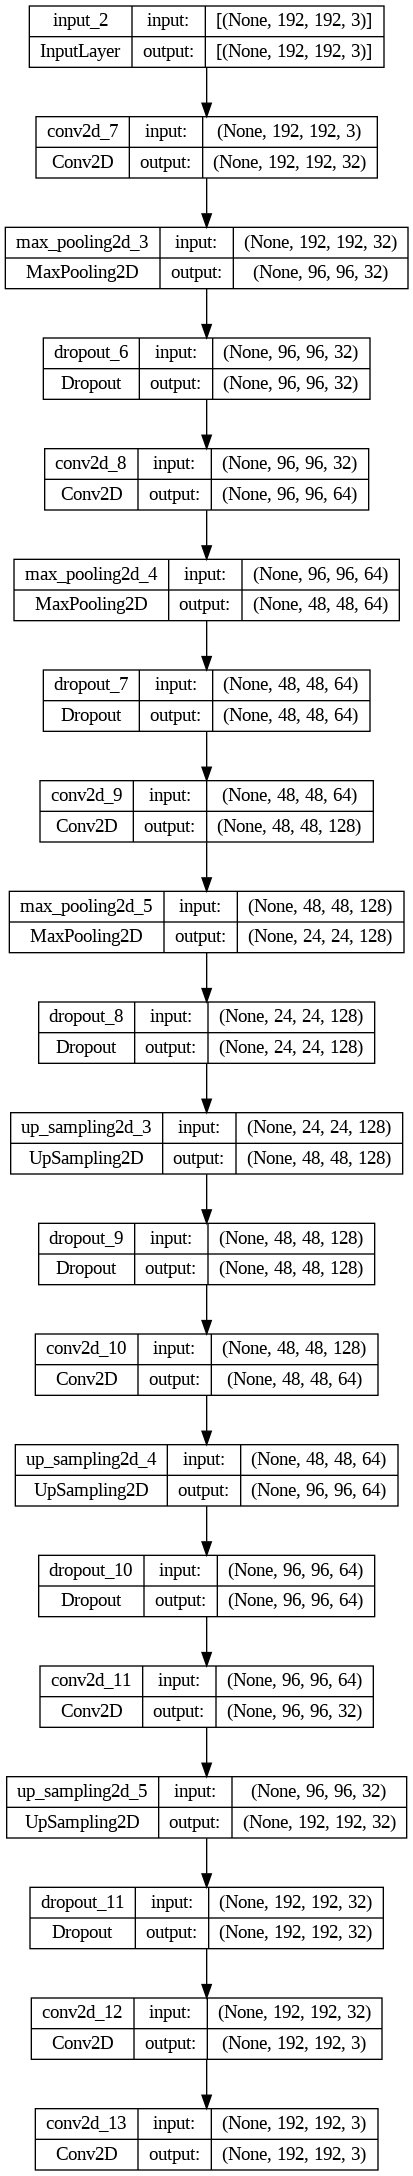

In [ ]:
tf.keras.utils.plot_model(
    autoencoder,
    # to_file="AE_model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    # show_layer_activations=False,
)

## 1.4 Train model

In [ ]:
# Training the Model
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5,
                             min_lr=0.00001, mode='auto', cooldown=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint =  ModelCheckpoint('GN_Denoising_AE.h5', save_best_only = True, monitor="val_accuracy")
callbacks = [reduce_lr, early_stop, model_checkpoint]

In [ ]:
# Training the model
x_train_n = []
x_train_noisy = []
print('Loading Train Data.....')
progress = tqdm(total = 10000, position = 0)
for x in range(10000):
  try:
      index = np.random.randint(0, len(images))
      img = tf.keras.utils.load_img(str(images[index]), target_size=(192,192,3))
      img = tf.keras.utils.img_to_array(img)/255.
      x_train_n.append(img)
      x_train_noisy.append(random_noise(img, 'gaussian', var=0.05))

      del images[index]
      progress.update(1)
  except:
      progress.update(1)
      print("Error loading image")

Loading Train Data.....


100%|██████████| 10000/10000 [43:48<00:00,  3.29it/s]

In [ ]:
print("Length: ", len(x_train_n))
print('Training the model....')
history_ae = autoencoder.fit(np.array(x_train_noisy), np.array(x_train_n),
              epochs=100,
              batch_size=32,
              shuffle=True,
              validation_split=0.15,
              callbacks=callbacks)

Length:  10000
Training the model....
Epoch 1/100
266/266 [==============================] - 15s 43ms/step - loss: 0.0730 - accuracy: 0.3451 - val_loss: 0.0350 - val_accuracy: 0.7278 - lr: 0.0010
Epoch 2/100
266/266 [==============================] - 9s 32ms/step - loss: 0.0078 - accuracy: 0.7416 - val_loss: 0.0163 - val_accuracy: 0.7678 - lr: 0.0010
Epoch 3/100
266/266 [==============================] - 9s 32ms/step - loss: 0.0060 - accuracy: 0.7636 - val_loss: 0.0117 - val_accuracy: 0.7866 - lr: 0.0010
Epoch 4/100
266/266 [==============================] - 8s 32ms/step - loss: 0.0053 - accuracy: 0.7706 - val_loss: 0.0090 - val_accuracy: 0.7290 - lr: 0.0010
Epoch 5/100
266/266 [==============================] - 8s 32ms/step - loss: 0.0049 - accuracy: 0.7317 - val_loss: 0.0081 - val_accuracy: 0.7524 - lr: 0.0010
Epoch 6/100
266/266 [==============================] - 8s 32ms/step - loss: 0.0046 - accuracy: 0.7342 - val_loss: 0.0068 - val_accuracy: 0.7555 - lr: 0.0010
Epoch 7/100
266/266

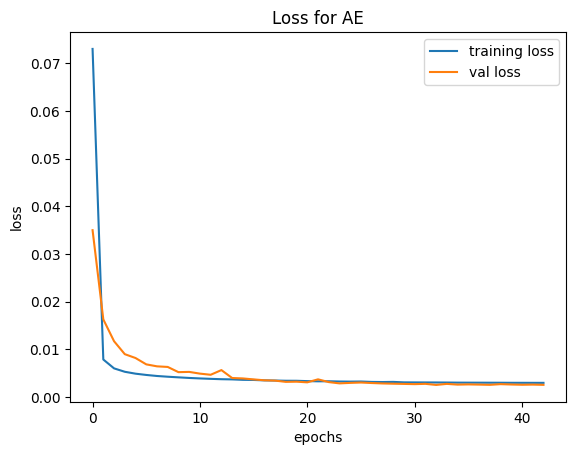

In [ ]:
# Plotting graphs for loss
plt.plot(history_ae.history['loss'], label='training loss')
plt.plot(history_ae.history['val_loss'], label='val loss')
plt.title('Loss for AE')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

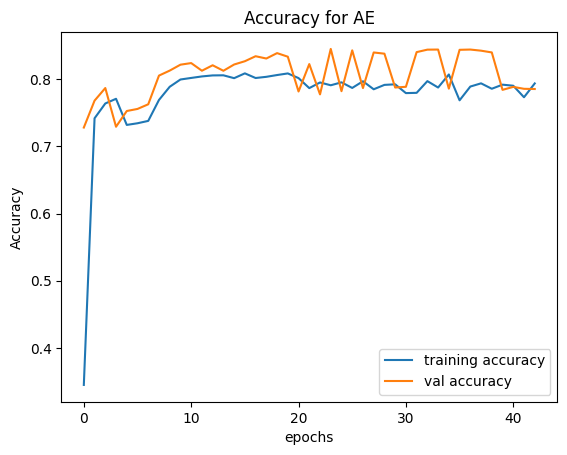

In [ ]:
# Plotting graphs for accuracy
plt.plot(history_ae.history['accuracy'], label='training accuracy')
plt.plot(history_ae.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy for AE')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

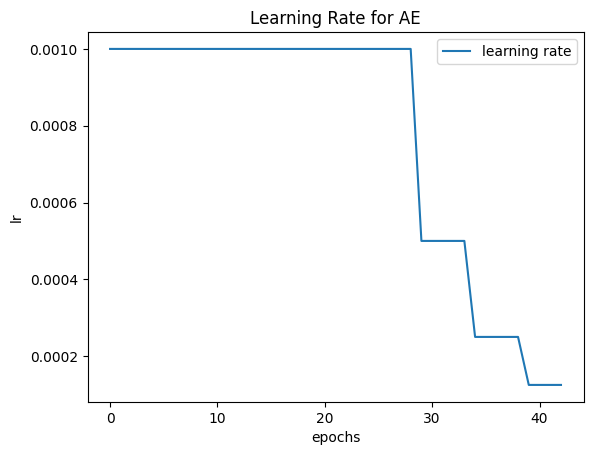

In [ ]:
# Plotting graphs for lr
plt.plot(history_ae.history['lr'], label='learning rate')
plt.title('Learning Rate for AE')
plt.xlabel('epochs')
plt.ylabel('lr')
plt.legend()
plt.show()


## 1.5 Test model

In [ ]:
x_test_n = []
x_test_noisy = []
progress = tqdm(total= len(images), position=0)
for img in images:
  img = tf.keras.utils.load_img(img, target_size=(192,192,3))
  img = tf.keras.utils.img_to_array(img)/255.
  x_test_n.append(img)
  x_test_noisy.append(random_noise(img, 'gaussian', var=0.05))
  progress.update(1)

100%|██████████| 3233/3233 [14:05<00:00,  3.66it/s]

In [ ]:
#Evalutaing the model on test_data set
print('AE Loss and Accuracy on Test dataset....')
results_AE = autoencoder.evaluate(np.array(x_test_noisy), np.array(x_test_n))
predictions_AE = autoencoder.predict(np.array(x_test_noisy))

# Represeting Model as JSON String
autoencoder_json = autoencoder.to_json()
with open('GN_Denoising_AE_model.json', 'w') as json_file:
  json_file.write(autoencoder_json)

AE Loss and Accuracy on Test dataset....
102/102 [==============================] - 1s 9ms/step


# 2 Convolutional Neural Network (CNN) Denoising

## 2.1 Build CNN model

In [ ]:
# Building a CNN Model
input_img = Input(shape=(192, 192, 3))
l1 = Conv2D(16, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(input_img)
l2 = Conv2D(16, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l1)
l3 = Dropout(0.2)(l2)

l4 = Conv2D(32, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l3)
l5 = Conv2D(32, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l4)
l6 = Dropout(0.2)(l5)

l7 = Conv2D(64, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l6)
l8 = Conv2D(64, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l7)
l9 = Dropout(0.2)(l8)

l10 = Conv2D(3, (3, 3), padding='same', activation=None,
                 activity_regularizer=regularizers.l1(10e-10))(l9)

# Create our network
cnn = Model(input_img, l10)

cnn.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
cnn.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 conv2d_14 (Conv2D)          (None, 192, 192, 16)      448       
                                                                 
 conv2d_15 (Conv2D)          (None, 192, 192, 16)      2320      
                                                                 
 dropout_12 (Dropout)        (None, 192, 192, 16)      0         
                                                                 
 conv2d_16 (Conv2D)          (None, 192, 192, 32)      4640      
                                                                 
 conv2d_17 (Conv2D)          (None, 192, 192, 32)      9248      
                                                                 
 dropout_13 (Dropout)        (None, 192, 192, 32)      0   

In [ ]:
tf.keras.utils.plot_model(
    cnn,
    # to_file="CNN_model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    # show_layer_activations=False,
)

## 2.2 Train model

In [ ]:
# Training the cnn model
model_checkpoint =  ModelCheckpoint('GN_Denoising_CNN.h5', save_best_only = True, monitor="val_accuracy")
callbacks = [reduce_lr, early_stop, model_checkpoint]

print("Length: ", len(x_train_n))
print('Training the model....')
history_cnn = cnn.fit(np.array(x_train_noisy), np.array(x_train_n),
              epochs=100,
              batch_size=32,
              shuffle=True,
              validation_split=0.15,
              callbacks=callbacks)

Length:  10000
Training the model....
Epoch 1/100
266/266 [==============================] - 34s 87ms/step - loss: 0.0130 - accuracy: 0.6464 - val_loss: 0.0093 - val_accuracy: 0.7627 - lr: 0.0010
Epoch 2/100
266/266 [==============================] - 16s 59ms/step - loss: 0.0041 - accuracy: 0.7315 - val_loss: 0.0096 - val_accuracy: 0.7849 - lr: 0.0010
Epoch 3/100
266/266 [==============================] - 16s 59ms/step - loss: 0.0032 - accuracy: 0.7558 - val_loss: 0.0088 - val_accuracy: 0.7825 - lr: 0.0010
Epoch 4/100
266/266 [==============================] - 16s 59ms/step - loss: 0.0029 - accuracy: 0.7618 - val_loss: 0.0077 - val_accuracy: 0.7883 - lr: 0.0010
Epoch 5/100
266/266 [==============================] - 16s 59ms/step - loss: 0.0027 - accuracy: 0.7671 - val_loss: 0.0079 - val_accuracy: 0.7907 - lr: 0.0010
Epoch 6/100
266/266 [==============================] - 16s 59ms/step - loss: 0.0025 - accuracy: 0.7727 - val_loss: 0.0076 - val_accuracy: 0.7759 - lr: 0.0010
Epoch 7/100
26

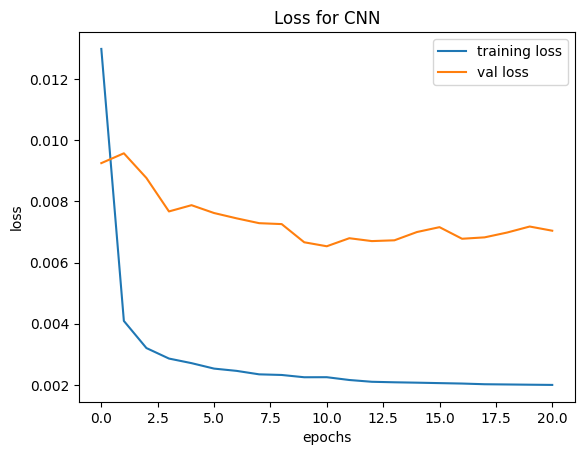

In [ ]:
# Plotting graphs for loss
plt.plot(history_cnn.history['loss'], label='training loss')
plt.plot(history_cnn.history['val_loss'], label='val loss')
plt.title('Loss for CNN')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

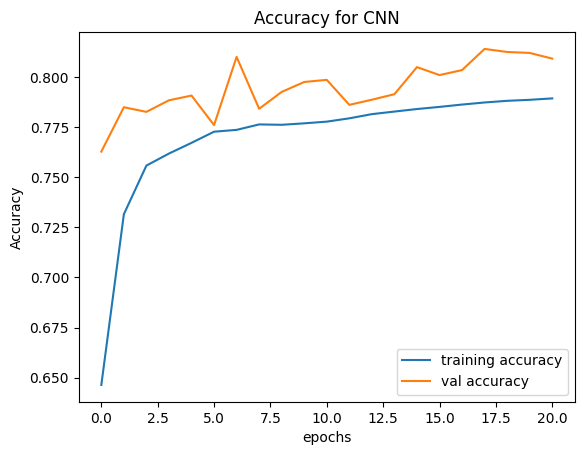

In [ ]:
# Plotting graphs for accuracy
plt.plot(history_cnn.history['accuracy'], label='training accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy for CNN')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

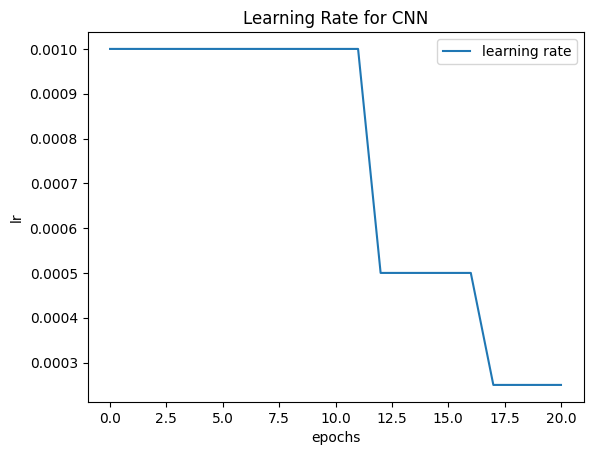

In [ ]:
# Plotting graphs for lr
plt.plot(history_cnn.history['lr'], label='learning rate')
plt.title('Learning Rate for CNN')
plt.xlabel('epochs')
plt.ylabel('lr')
plt.legend()
plt.show()

## 2.3 Test model

In [ ]:
#Evalutaing the model on test_data set
print('CNN Loss and Accuracy on Test dataset...')
results_CNN = cnn.evaluate(np.array(x_test_noisy), np.array(x_test_n))
predictions_CNN = cnn.predict(np.array(x_test_noisy))

# Represeting Model as JSON String
cnn_json = cnn.to_json()
with open('GN_Denoising_CNN_model.json', 'w') as json_file:
  json_file.write(cnn_json)

CNN Loss and Accuracy on Test dataset...
102/102 [==============================] - 2s 13ms/step


# 3 Comparison between AE and CNN denoising

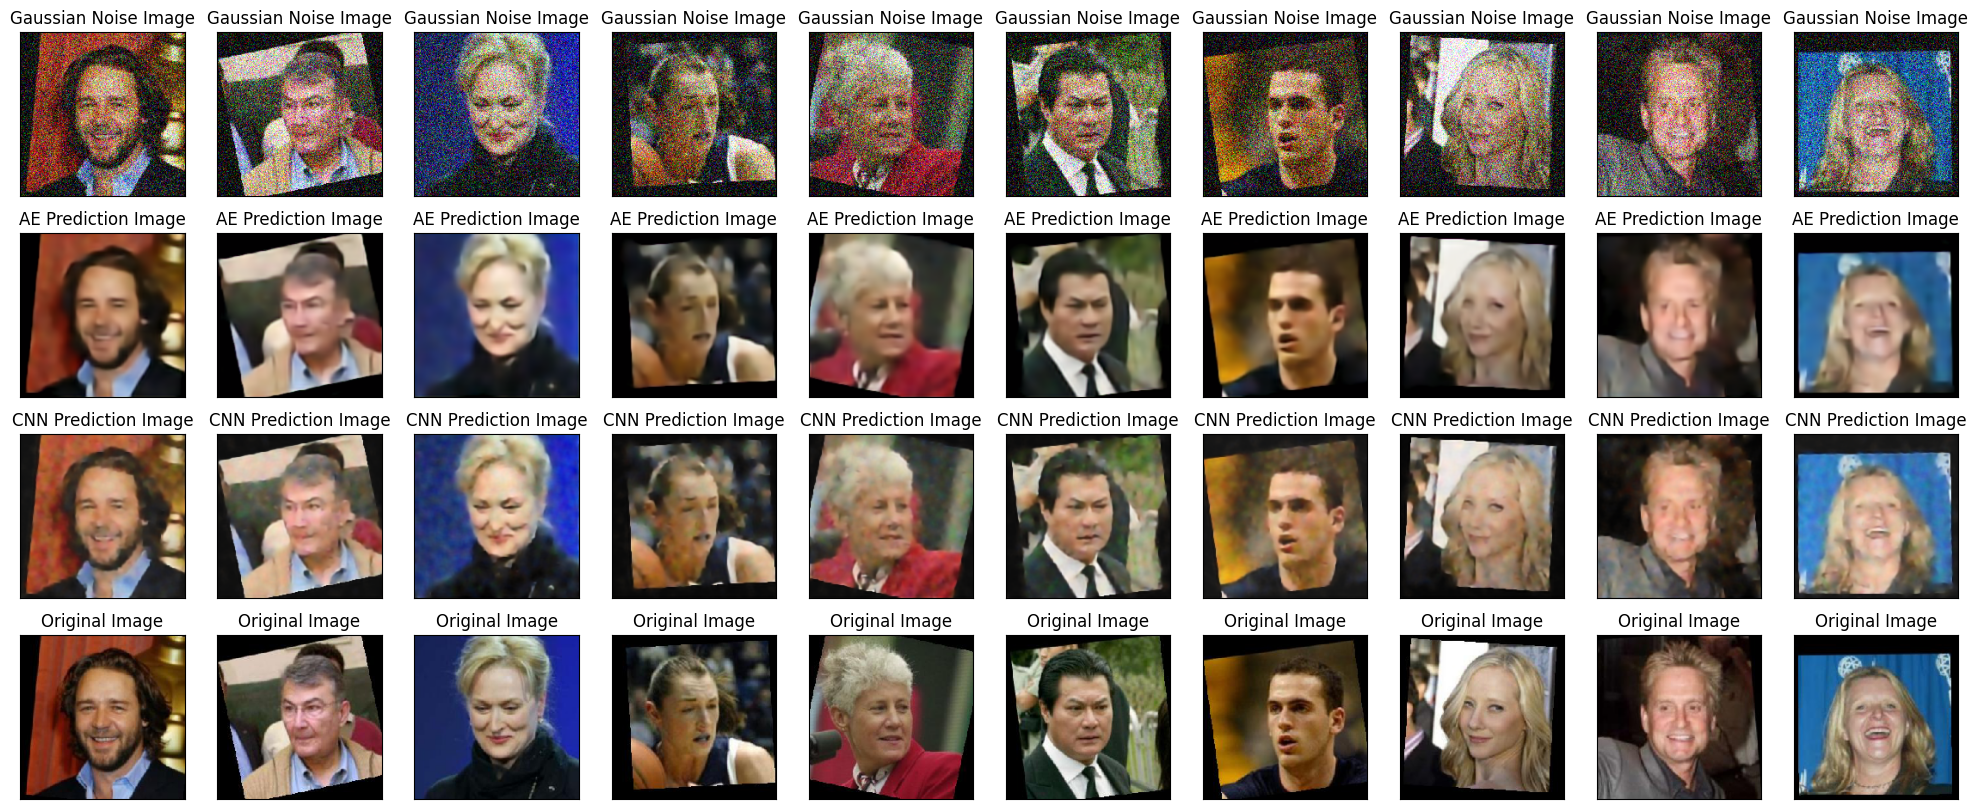

In [ ]:
n = 10
plt.figure(figsize= (25,10))
for i in range(n):
  ax = plt.subplot(4, n, i+1)
  index = np.random.randint(0, len(x_test_n))
  act_img = tf.keras.utils.array_to_img(x_test_noisy[index])
  plt.imshow(act_img, cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title('Gaussian Noise Image')
  ax = plt.subplot(4, n, i+1+n)
  pred_ae = tf.keras.utils.array_to_img(predictions_AE[index])
  plt.imshow(pred_ae, cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title('AE Prediction Image')
  ax = plt.subplot(4, n, i+11+n)
  pred_cnn = tf.keras.utils.array_to_img(predictions_CNN[index])
  plt.imshow(pred_cnn, cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title('CNN Prediction Image')
  ax = plt.subplot(4, n, i+21+n)
  plt.imshow(x_test_n[index])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title('Original Image')
plt.show()